<a href="https://colab.research.google.com/github/JuanMa312/Challenge-Telecom-X-analisis-de-evasion-de-clientes---Parte-2/blob/main/TelecomX_LATAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importacion de Bibliotecas

In [1]:
# Importación de librerías esenciales

# Manipulación de datos
import pandas as pd # Manipulación de datos
import numpy as np # Manipulación de datos

# Visualización de Datos
import matplotlib.pyplot as plt # Visualización de Datos
import seaborn as sns # Visualización de Datos

# Preprocesamiento y modelado
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, confusion_matrix,
    RocCurveDisplay
)

from sklearn.inspection import permutation_importance

# Modelos que se utilizarán más adelante
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Estadística
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Utilidades adicionales
# Advertencias (para limpiar outputs si es necesario)
import warnings
warnings.filterwarnings("ignore")

# La función collections.Counter() en Python sirve para contar la frecuencia de
# elementos en una secuencia iterable (como una lista, una cadena, etc.).
from collections import Counter

In [22]:

# URL cruda del CSV en GitHub (ajústala si cambias el archivo o su ubicación)
CSV_URL = "https://raw.githubusercontent.com/Alxs68/TelecomX_2_LATAM-ML/main/telecomx_datos_procesados.csv"

# Lee el CSV (asumimos coma como separador y punto como decimal). Cambia si tu archivo usa otras convenciones.
df = pd.read_csv(CSV_URL, sep=",", decimal=".", low_memory=False)
print("Forma del dataset:", df.shape)
display(df.head(3))

# Validación de columnas mínimas
EXPECTED_TARGET = "CHURN_FLAG"
EXPECTED_ID = "ID_CLIENTE"

missing = [c for c in [EXPECTED_TARGET, EXPECTED_ID] if c not in df.columns]
if missing:
    print("\n⚠️ Columnas esperadas faltantes:", missing)
    print("   Por favor, ajusta los nombres abajo si en tu dataset se llaman distinto.")
else:
    print("\n✅ Columnas clave detectadas: CHURN_FLAG e ID_CLIENTE")

Forma del dataset: (7267, 22)


,ID_CLIENTE,CHURN,GENERO,ADULTO_MAYOR,PAREJA,DEPENDIENTES,ANTIGUEDAD_MESES,SERVICIO_TELEFONICO,LINEAS_MULTIPLES,TIPO_INTERNET,...,PROTECCION_DISPOSITIVO,SOPORTE_TECNICO,STREAMING_TV,STREAMING_PELICULAS,TIPO_CONTRATO,FACTURACION_ELECTRONICA,METODO_PAGO,CARGO_MENSUAL,CARGO_TOTAL,CHURN_FLAG
0,0002-ORFBO,No,Mujer,0,Si,Si,9,Si,No,DSL,...,No,Si,Si,No,Un año,Si,Cheque por correo,656,5933.0,0.0
1,0003-MKNFE,No,Hombre,0,No,No,9,Si,Si,DSL,...,No,No,No,Si,Mes a mes,No,Cheque por correo,599,5424.0,0.0
2,0004-TLHLJ,Si,Hombre,0,No,No,4,Si,No,Fibra óptica,...,Si,No,No,No,Mes a mes,Si,Cheque electrónico,739,28085.0,1.0



✅ Columnas clave detectadas: CHURN_FLAG e ID_CLIENTE


In [23]:

print("Columnas del dataset:")
print(df.columns.tolist())

Columnas del dataset:
['ID_CLIENTE', 'CHURN', 'GENERO', 'ADULTO_MAYOR', 'PAREJA', 'DEPENDIENTES', 'ANTIGUEDAD_MESES', 'SERVICIO_TELEFONICO', 'LINEAS_MULTIPLES', 'TIPO_INTERNET', 'SEGURIDAD_EN_LINEA', 'RESPALDO_EN_LINEA', 'PROTECCION_DISPOSITIVO', 'SOPORTE_TECNICO', 'STREAMING_TV', 'STREAMING_PELICULAS', 'TIPO_CONTRATO', 'FACTURACION_ELECTRONICA', 'METODO_PAGO', 'CARGO_MENSUAL', 'CARGO_TOTAL', 'CHURN_FLAG']


In [24]:
# Separación en entrenamiento (con etiqueta) y scoring (sin etiqueta)
if EXPECTED_TARGET in df.columns:
    df_train = df[df[EXPECTED_TARGET].notnull()].copy()
    df_score = df[df[EXPECTED_TARGET].isnull()].copy()
else:
    raise SystemExit("❌ No se encontró la columna objetivo 'churn'. Renombra tu columna objetivo a 'churn' y vuelve a ejecutar.")

print("Tamaño df_train:", df_train.shape)
print("Tamaño df_score:", df_score.shape)

# Vista rápida de la variable objetivo
print("\nDistribución de churn (df_train):")
display(df_train[EXPECTED_TARGET].value_counts(dropna=False))
print("\nProporción de clases:")
display(df_train[EXPECTED_TARGET].value_counts(normalize=True).rename("proporcion"))



Tamaño df_train: (7043, 22)
Tamaño df_score: (224, 22)

Distribución de churn (df_train):


,count
CHURN_FLAG,
0.0,5174
1.0,1869



Proporción de clases:


,proporcion
CHURN_FLAG,
0.0,0.73463
1.0,0.26537


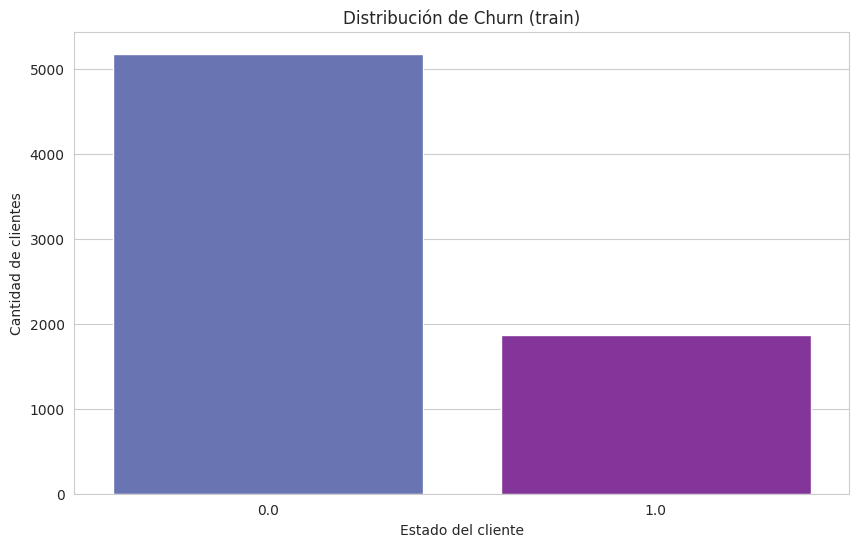

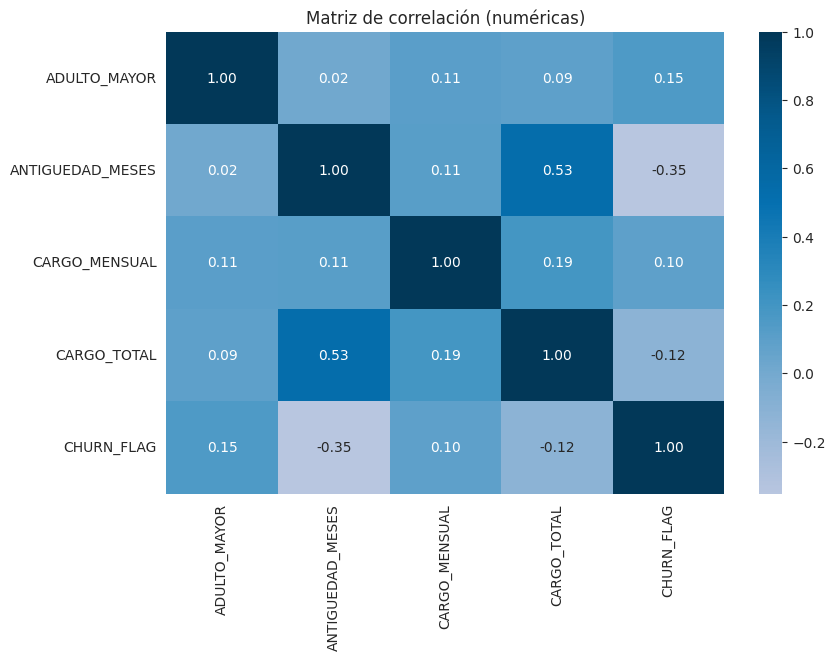

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración estética
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

# Colores personalizados: azul para activos, morado para inactivos
colors = ['#5C6BC0', '#8E24AA']

# 1. Conteo de churn
sns.countplot(x=EXPECTED_TARGET, data=df_train, palette=colors)
plt.title("Distribución de Churn (train)")
plt.xlabel("Estado del cliente")
plt.ylabel("Cantidad de clientes")
plt.show()

# 2. Matriz de correlación de variables numéricas con gradiente azul-morado
corr = df_train.corr(numeric_only=True)
plt.figure(figsize=(9,6))
sns.heatmap(corr, cmap="PuBu", center=0, annot=True, fmt=".2f")
plt.title("Matriz de correlación (numéricas)")
plt.show()


In [34]:
# Definir X e y (eliminar 'CHURN_FLAG', 'ID_CLIENTE' y 'CHURN' de las predictoras)
X = df_train.drop(columns=[EXPECTED_TARGET] + ([EXPECTED_ID] if EXPECTED_ID in df_train.columns else []) + ['CHURN'], errors="ignore")
y = df_train[EXPECTED_TARGET]

# Detección de tipos
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numéricas:", num_cols[:12], "..." if len(num_cols)>12 else "")
print("Categóricas:", cat_cols[:12], "..." if len(cat_cols)>12 else "")

# Preprocesador: imputa faltantes, escala numéricas y One-Hot en categóricas
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

preprocessor = ColumnTransformer(
    transformers=[
        # Aquí se imputan las columnas numéricas (incluyendo CARGO_TOTAL) con la mediana
        ("num", Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), num_cols),
        # Aquí se imputan y codifican las categóricas
        ("cat", Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
    ]
)

Numéricas: ['ADULTO_MAYOR', 'ANTIGUEDAD_MESES', 'CARGO_MENSUAL', 'CARGO_TOTAL'] 
Categóricas: ['GENERO', 'PAREJA', 'DEPENDIENTES', 'SERVICIO_TELEFONICO', 'LINEAS_MULTIPLES', 'TIPO_INTERNET', 'SEGURIDAD_EN_LINEA', 'RESPALDO_EN_LINEA', 'PROTECCION_DISPOSITIVO', 'SOPORTE_TECNICO', 'STREAMING_TV', 'STREAMING_PELICULAS'] ...


In [35]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y if y.nunique()<=10 else None
)
print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (4930, 19) X_test: (2113, 19)


<Figure size 600x500 with 0 Axes>

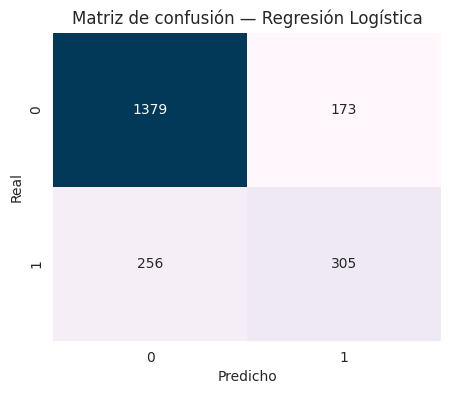

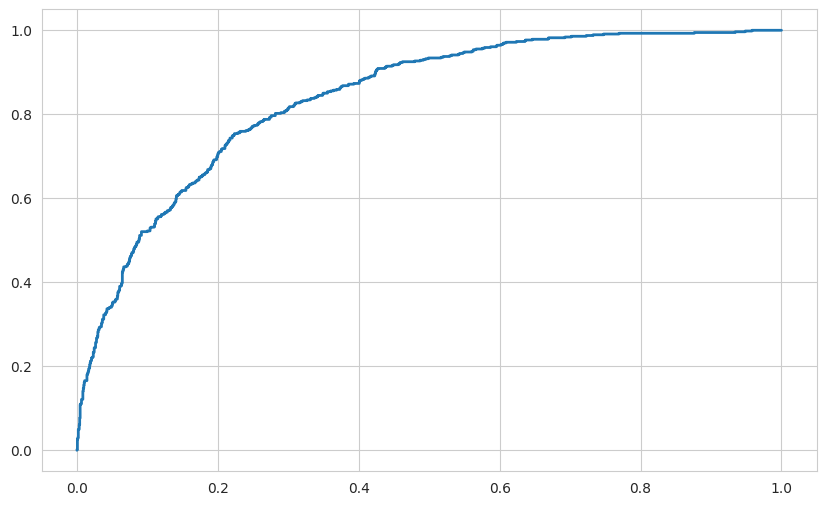

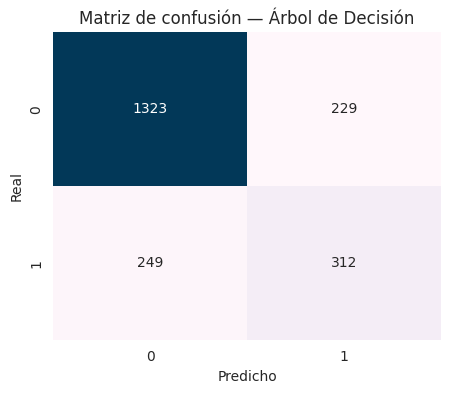

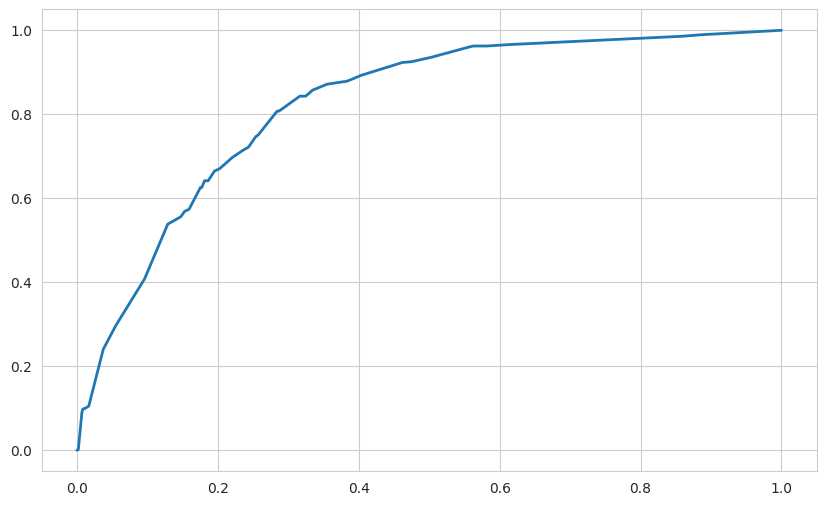

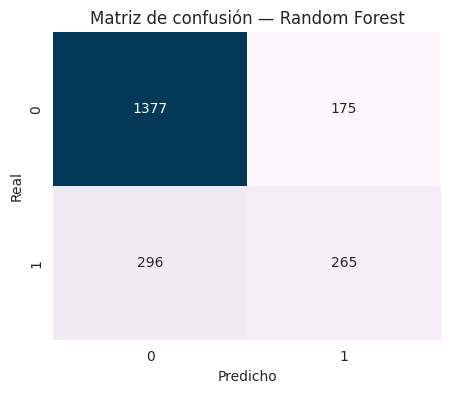

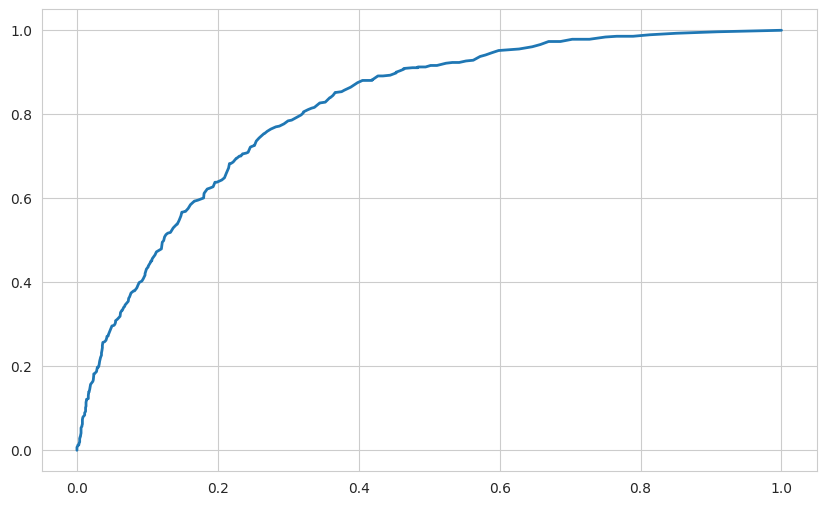

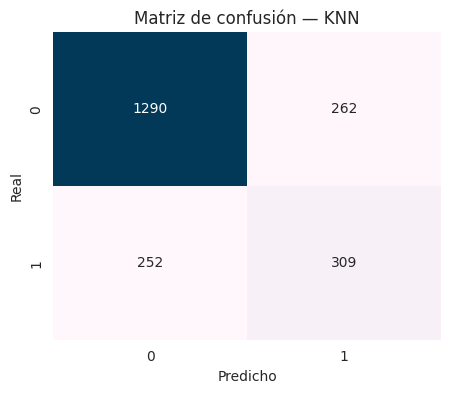

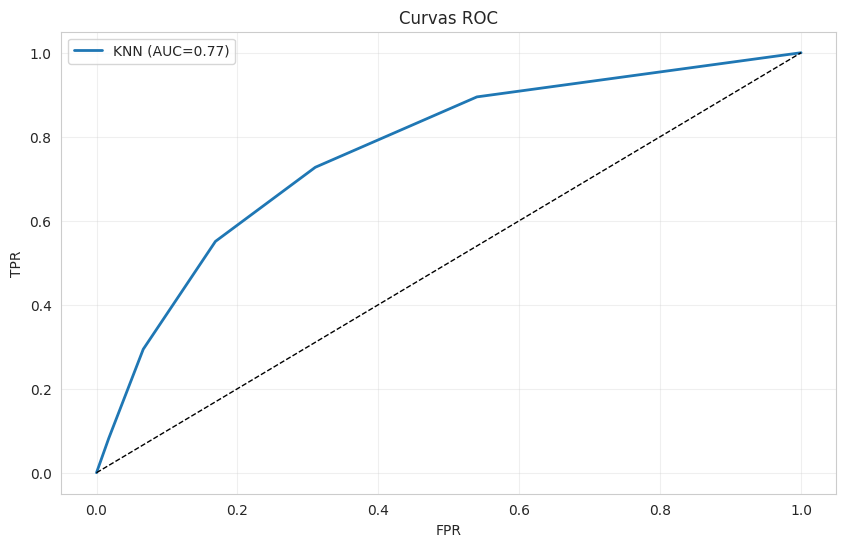


Resumen de métricas:


,Modelo,Accuracy,Precision,Recall,F1,AUC
0,Regresión Logística,0.796971,0.638075,0.543672,0.587103,0.838239
1,Árbol de Decisión,0.773781,0.576710,0.556150,0.566243,0.822162
2,Random Forest,0.777094,0.602273,0.472371,0.529471,0.813523
3,KNN,0.756744,0.541156,0.550802,0.545936,0.765688


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Modelos
modelos = {
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "Árbol de Decisión": DecisionTreeClassifier(max_depth=6, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

resultados = []

# Colores azul/morado
palette_cm = sns.color_palette(["#5C6BC0", "#8E24AA"])

plt.figure(figsize=(6,5))
for i, (nombre, modelo) in enumerate(modelos.items()):
    pipe = Pipeline([("prep", preprocessor), ("clf", modelo)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe.named_steps["clf"], "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    resultados.append([nombre, acc, prec, rec, f1, auc])

    # Matriz de confusión con colores azul/morado
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="PuBu", cbar=False)
    plt.title(f"Matriz de confusión — {nombre}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

    # Curva ROC
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.2f})", linewidth=2)

# Curva ROC final
plt.plot([0,1],[0,1],"k--", linewidth=1)
plt.title("Curvas ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Resumen de métricas
res_df = pd.DataFrame(resultados, columns=["Modelo","Accuracy","Precision","Recall","F1","AUC"])
print("\nResumen de métricas:")
display(res_df.sort_values("AUC", ascending=False))


In [38]:

# Elegimos el modelo con mayor AUC (si no tiene AUC, priorizamos F1)
mejor_fila = res_df.sort_values(["AUC","F1","Accuracy"], ascending=False).iloc[0]
mejor_nombre = mejor_fila["Modelo"]
print("🏆 Mejor modelo:", mejor_nombre)

# Instanciar el mejor modelo con el mismo preprocesamiento
mejor_map = {
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "Árbol de Decisión": DecisionTreeClassifier(max_depth=6, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}
mejor_modelo = Pipeline([("prep", preprocessor), ("clf", mejor_map[mejor_nombre])])
mejor_modelo.fit(X, y)

# Preparar X_score y predecir
if df_score.shape[0] > 0:
    X_score = df_score.drop(columns=[EXPECTED_TARGET] + ([EXPECTED_ID] if EXPECTED_ID in df_score.columns else []), errors="ignore")
    # Probabilidad si el clasificador lo soporta
    if hasattr(mejor_modelo.named_steps["clf"], "predict_proba"):
        df_score["prob_churn"] = mejor_modelo.predict_proba(X_score)[:,1]
    else:
        # Si no hay predict_proba (p.ej., SVM sin probas), aproximamos con 0/1
        df_score["prob_churn"] = mejor_modelo.predict(X_score).astype(float)
    df_score["prediccion"] = (df_score["prob_churn"] >= 0.5).astype(int)

    # Exportar
    cols_out = []
    if EXPECTED_ID in df_score.columns:
        cols_out.append(EXPECTED_ID)
    cols_out += ["prediccion", "prob_churn"]
    df_score[cols_out].to_csv("score_churn.csv", index=False, encoding="utf-8-sig")
    print("✅ Archivo 'score_churn.csv' generado.")
else:
    print("ℹ️ No hay filas en df_score (todas las filas tienen churn). No se genera archivo de scoring.")



🏆 Mejor modelo: Regresión Logística
✅ Archivo 'score_churn.csv' generado.


Top 15 coeficientes por magnitud (Regresión Logística):


,0
ANTIGUEDAD_MESES,-0.884495
TIPO_CONTRATO_Dos años,-0.772497
TIPO_CONTRATO_Mes a mes,0.567700
TIPO_INTERNET_DSL,-0.492074
TIPO_INTERNET_Fibra óptica,0.393978
FACTURACION_ELECTRONICA_No,-0.319636
LINEAS_MULTIPLES_No,-0.283543
SERVICIO_TELEFONICO_Si,-0.275758
DEPENDIENTES_Si,-0.234041
SEGURIDAD_EN_LINEA_Si,-0.233684


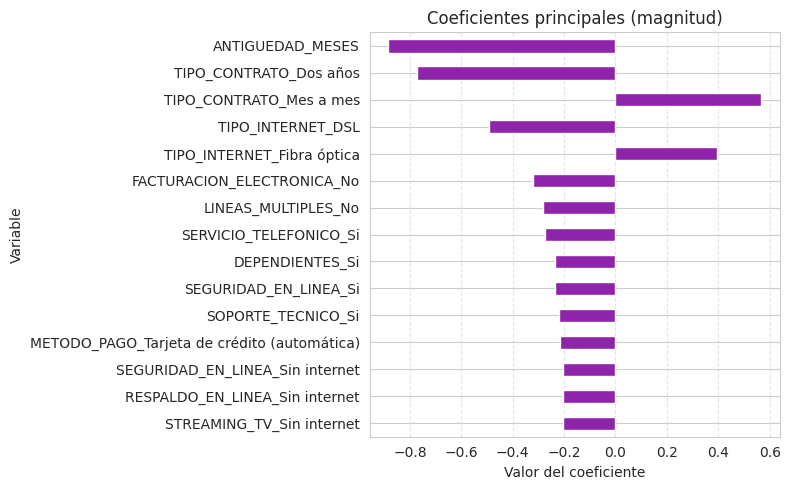

In [43]:
clf = mejor_modelo.named_steps["clf"]

# Extraer nombres de columnas transformadas
ohe = mejor_modelo.named_steps["prep"].named_transformers_["cat"]
num_cols = mejor_modelo.named_steps["prep"].transformers_[0][2]
cat_cols = mejor_modelo.named_steps["prep"].transformers_[1][2]
ohe_names = list(ohe.get_feature_names_out(cat_cols)) if hasattr(ohe, "get_feature_names_out") else []
feat_names = list(num_cols) + ohe_names

# --- Para modelos con feature_importances_ (Random Forest, Decision Tree) ---
if hasattr(clf, "feature_importances_"):
    imps = pd.Series(clf.feature_importances_, index=feat_names).sort_values(ascending=False).head(15)
    print("Top 15 variables (importancia):")
    display(imps)

    plt.figure(figsize=(8,5))
    imps.iloc[::-1].plot(kind="barh", color="#5C6BC0")  # Azul consistente
    plt.title("Importancia de variables (Top 15)", fontsize=12)
    plt.xlabel("Importancia")
    plt.ylabel("Variable")
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# --- Para Regresión Logística ---
elif hasattr(clf, "coef_"):
    coefs = pd.Series(clf.coef_[0], index=feat_names).sort_values(key=np.abs, ascending=False).head(15)
    print("Top 15 coeficientes por magnitud (Regresión Logística):")
    display(coefs)

    plt.figure(figsize=(8,5))
    coefs.iloc[::-1].plot(kind="barh", color="#8E24AA")  # Morado
    plt.title("Coeficientes principales (magnitud)", fontsize=12)
    plt.xlabel("Valor del coeficiente")
    plt.ylabel("Variable")
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

else:
    print("El mejor modelo no expone importancias ni coeficientes para interpretar.")



In [40]:
if 'prediccion' in df_score.columns:
    print("Recuento de predicciones de Churn en df_score:")
    display(df_score['prediccion'].value_counts())
else:
    print("La columna 'prediccion' no se encuentra en df_score. Asegúrate de haber ejecutado la celda de scoring (celda ad43af99).")


Recuento de predicciones de Churn en df_score:


,count
prediccion,
0,169
1,55


In [41]:

print("Distribución de churn (df_train):")
display(df_train[EXPECTED_TARGET].value_counts(dropna=False))
print("\nProporción de clases:")
display(df_train[EXPECTED_TARGET].value_counts(normalize=True).rename("proporcion"))

Distribución de churn (df_train):


,count
CHURN_FLAG,
0.0,5174
1.0,1869



Proporción de clases:


,proporcion
CHURN_FLAG,
0.0,0.73463
1.0,0.26537


In [42]:
if 'prob_churn' in df_score.columns and EXPECTED_ID in df_score.columns:
    print("Clientes con escala de colores por probabilidad de Churn (Scoring), ordenados por probabilidad:")
    # Ordenar por 'prob_churn' de mayor a menor
    df_score_sorted = df_score.sort_values(by='prob_churn', ascending=False).copy()
    # Aplicar escala de colores a las columnas 'prob_churn' y 'ID_CLIENTE' (Rojo más intenso para alta prob)
    # Usamos gmap para basar el color en 'prob_churn' para ambas columnas
    styled_df = df_score_sorted.style.background_gradient(subset=[EXPECTED_ID, 'prob_churn'],
                                                         cmap='Reds',
                                                         gmap=df_score_sorted['prob_churn'])
    display(styled_df)
elif 'prob_churn' in df_score.columns:
     print("Clientes con escala de colores por probabilidad de Churn (Scoring), ordenados por probabilidad:")
    # Ordenar por 'prob_churn' de mayor a menor
     df_score_sorted = df_score.sort_values(by='prob_churn', ascending=False).copy()
    # Aplicar escala de colores a la columna 'prob_churn' (Verde oscuro para alta prob)
     styled_df = df_score_sorted.style.background_gradient(subset=['prob_churn'], cmap='Greens')
     display(styled_df)
elif EXPECTED_ID not in df_score.columns:
    print(f"⚠️ La columna '{EXPECTED_ID}' no se encuentra en df_score.")
else:
    print("⚠️ La columna 'prob_churn' no se encuentra en df_score. Asegúrate de haber ejecutado la celda de scoring (celda ad43af99).")

Clientes con escala de colores por probabilidad de Churn (Scoring), ordenados por probabilidad:


,ID_CLIENTE,CHURN,GENERO,ADULTO_MAYOR,PAREJA,DEPENDIENTES,ANTIGUEDAD_MESES,SERVICIO_TELEFONICO,LINEAS_MULTIPLES,TIPO_INTERNET,SEGURIDAD_EN_LINEA,RESPALDO_EN_LINEA,PROTECCION_DISPOSITIVO,SOPORTE_TECNICO,STREAMING_TV,STREAMING_PELICULAS,TIPO_CONTRATO,FACTURACION_ELECTRONICA,METODO_PAGO,CARGO_MENSUAL,CARGO_TOTAL,CHURN_FLAG,prob_churn,prediccion
4579,6272-HWGNQ,nan,Mujer,0,No,No,1,Si,Si,Fibra óptica,No,No,No,No,No,Si,Mes a mes,Si,Cheque electrónico,850,85.000000,nan,0.800085,1
4976,6807-HWZBE,nan,Hombre,0,Si,No,2,Si,Si,Fibra óptica,No,No,Si,No,Si,No,Mes a mes,Si,Cheque electrónico,9145,17145.000000,nan,0.791110,1
4396,6022-MXOMF,nan,Mujer,1,No,No,1,Si,Si,Fibra óptica,No,No,No,No,No,No,Mes a mes,Si,Cheque electrónico,742,742.000000,nan,0.790135,1
1657,2353-VPYNS,nan,Hombre,1,No,No,1,Si,Si,Fibra óptica,No,No,No,No,No,No,Mes a mes,Si,Cheque electrónico,7365,7365.000000,nan,0.789749,1
3202,4471-OIIDG,nan,Mujer,0,No,No,10,Si,Si,Fibra óptica,No,No,Si,No,Si,Si,Mes a mes,Si,Cheque electrónico,1006,10602.000000,nan,0.789198,1
5714,7808-NBWYW,nan,Mujer,1,Si,No,3,Si,No,Fibra óptica,No,No,No,No,Si,No,Mes a mes,Si,Cheque electrónico,804,22405.000000,nan,0.772946,1
4860,6648-RXFRG,nan,Hombre,0,No,No,7,Si,Si,Fibra óptica,No,No,No,No,No,Si,Mes a mes,Si,Cheque electrónico,868,62035.000000,nan,0.764095,1
374,0534-JRNIG,nan,Mujer,0,No,No,6,Si,Si,Fibra óptica,No,No,No,No,Si,Si,Mes a mes,Si,Transferencia bancaria (automática),9355,5364.000000,nan,0.763587,1
3619,4988-RZJHG,nan,Mujer,0,Si,No,8,Si,Si,Fibra óptica,No,No,No,No,No,Si,Mes a mes,Si,Cheque electrónico,849,76495.000000,nan,0.762017,1
2733,3781-LIPVO,nan,Mujer,0,Si,No,7,Si,Si,Fibra óptica,No,No,No,No,Si,No,Mes a mes,Si,Cheque electrónico,865,5825.000000,nan,0.759907,1
